```
title: "Cloning traceroute from Scratch"
date: 2021-07-25
```

[`traceroute`](https://en.wikipedia.org/wiki/Traceroute) is a cool little tool that lets you see how your network packets travel through the network. If you've ever heard anyone talk about ["network hops"](https://en.wikipedia.org/wiki/Hop_(networking)), `traceroute` will show you exactly what these hops are (well, if it can). A basic implementation is super simple and relies on the definition of a [TTL (time-to-live)](https://en.wikipedia.org/wiki/Time_to_live). Each packet in the network has a time-to-live associated with it, in practice it's simply a number that increments on each network hop. If any host in the path to the destination sees that the TTL has exceeded the packet's stated maximum TTL, the packet is dead and can be considered garbage.

Let's first look at a real `traceroute`'s output in detail. Your results will be different since I'm guessing we're not in the same computer.

```bash
$ traceroute example.com
traceroute to example.com (93.184.216.34), 30 hops max, 60 byte packets
 < I omitted some paths for privacy / brevity >
 7  242.0.31.17 (242.0.31.17)  0.384 ms 100.95.17.155 (100.95.17.155)  0.689 ms 100.95.1.145 (100.95.1.145)  0.961 ms
 8  100.95.1.133 (100.95.1.133)  0.987 ms *  0.970 ms 100.95.17.137 (100.95.17.137)  0.290 ms
 9  100.100.2.32 (100.100.2.32)  2.134 ms 100.100.2.82 (100.100.2.82)  0.895 ms 100.100.2.40 (100.100.2.40)  0.876 ms
 < I omitted some paths for privacy / brevity >
```

I took out many entries, here we only see 7-9 but the real output had 25 hops total (that's a lot!). Each hop shows the index in the path (e.g. `7`, `8`, ...) and the hosts it saw. By default `traceroute` sets the relevant TTL and sends out the packet 3 times. For factors outside your control (decisions in your ISP / intermediate ASes), packets may take a different path each time. We see here this is often the case, as the IPs traversed are unique on every attempt. Each entry shows the host it reached (e.g. `242.0.31.17` and the time it took `0.384 ms`). Theoretically adding up all these times should give you the same time as `ping example.com`, but due to routing decisions / queueing delay this is difficult to achieve in practice.

In the [`ping` clone](/posts/ping-clone/) post, we used ICMP to send packets to a destination to see if it's reachable. We'll do the same thing here, but intentionally set the TTL too low so the packet gets killed. A nice side effect is that the host that does the killing will tell us what happened, so we can identify each hop along the network if we set a TTL to expire at each hop. This of course relies on intermediate hosts playing along, which they don't always do for policy/firewall reasons.

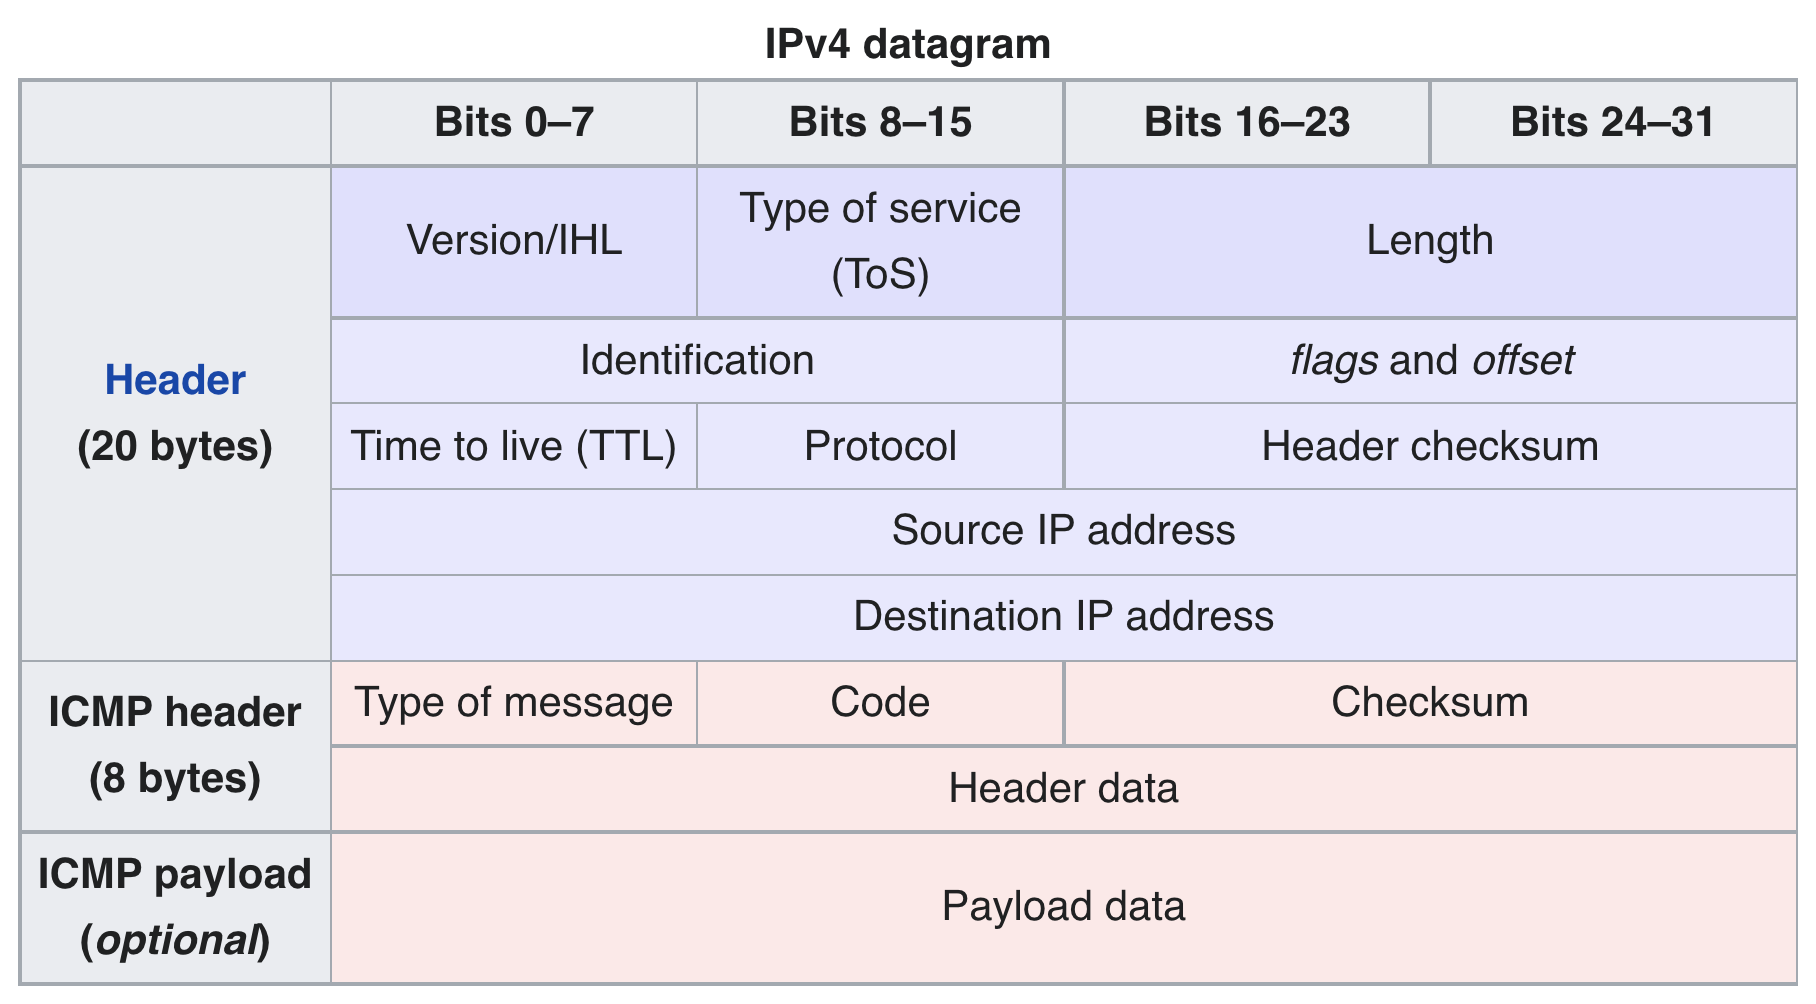

If we consult the holy ICMP ping packet diagram again, we see there is a TTL field we can set but that it is in the IPv4 header. Python copies the Unix socket API nearly directly, which lets you change these by setting options on your socket. So we don't need to touch the previous `ping` implementation at all.

In [8]:
# Grab the ping implementation from
# https://goatmobile.biz/posts/ping-clone
from ipynb.fs.full.Ping import ping
from typing import List
import socket
import struct

# If we've looked at more than this many hops, give up
MAX_HOPS = 60
ICMP_PROTOCOL = 0x1

# A little utility to turn IPv4 addresses from a 32-bit integer
# to the familiar octet format
def readable_ip(ip: int) -> str:
    ip_bytes = struct.pack(">I", ip)
    octets = struct.unpack(">BBBB", ip_bytes)

    return ".".join([str(int(octet)) for octet in octets])

def traceroute(destination: str) -> List[str]:
    # Look up IP address of the hostname we're concerned with
    destination_ip = socket.gethostbyname(destination)

    # Just as in the ping post, create a raw ICMP socket
    my_socket = socket.socket(socket.AF_INET, socket.SOCK_RAW, proto=ICMP_PROTOCOL)
    
    routes = []
    
    for i in range(MAX_HOPS):
        # This sets the TTL in the IPv4 header. SOL_IP means to set an option
        # at the network (IP) layer, and IP_TTL is the actual option to set
        my_socket.setsockopt(socket.SOL_IP, socket.IP_TTL, i + 1)
        
        # Send out the packet
        rtt_ms, ttl, _, hop_ip = ping(my_socket, destination, sequence_number=i)
        
        # Convert the IP into a readable form
        reabable_hop_ip = readable_ip(hop_ip)
        routes.append((reabable_hop_ip, rtt_ms))
        
        # If the hop is the end of the line, don't do anything else
        # (the will just return the same data as this hop)
        if reabable_hop_ip == destination_ip:
            break
    
    return routes

This has everything needed to run a simple traceroute. For simplicity it only checks one path (and only supports IPv4).

In [13]:
destination = "example.com"
routes = traceroute(destination)

# Chopping off some of the more personal routes
routes = routes[5:]

if __name__ == "__main__":
    print(f"traceroute to {destination}, {MAX_HOPS} hops max")
    print(" < some routes omitted >")
    for index, (route, rtt_ms) in enumerate(routes):
        print(f" {5 + 1 + index} {route} {round(rtt_ms, 2)} ms")

traceroute to example.com, 60 hops max
 < some routes omitted >
 6 192.205.32.238 7.22 ms
 7 152.195.85.131 6.41 ms
 8 93.184.216.34 5.75 ms


That's all there is to it. Just kidding, [BSD's `traceroute`](https://github.com/openbsd/src/blob/master/usr.sbin/traceroute/traceroute.c) clocks in at over 1000 lines of C, with many other options such as:
* Use TCP, [UDPLITE](https://en.wikipedia.org/wiki/UDP-Lite), or [DCCP](https://en.wikipedia.org/wiki/Datagram_Congestion_Control_Protocol) instead of ICMP
* Show hostnames when possible along with IP addresses
* A bunch of options to control the various parameters (max hops, wait time, simultaneous pings, etc.)